#### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
import seaborn as sns
from scipy import stats
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, r2_score, mean_squared_error

#### Load data

In [2]:
df = pd.read_csv(r"C:\Users\ASM9015\Downloads\Cars Datasets 2025.csv", encoding="latin1")
#df["Fuel Types"].value_counts()

In [3]:
print("Dataframe's shape: ", df.shape,'\n')
print(df.info(),'\n')
print(df.describe(),'\n')
print(df.columns,'\n')

df.columns = df.columns.str.replace(' ', '_')  
print(df.columns,'\n')

Dataframe's shape:  (1218, 11) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Company Names              1218 non-null   object
 1   Cars Names                 1218 non-null   object
 2   Engines                    1218 non-null   object
 3   CC/Battery Capacity        1215 non-null   object
 4   HorsePower                 1218 non-null   object
 5   Total Speed                1218 non-null   object
 6   Performance(0 - 100 )KM/H  1212 non-null   object
 7   Cars Prices                1218 non-null   object
 8   Fuel Types                 1218 non-null   object
 9   Seats                      1218 non-null   object
 10  Torque                     1217 non-null   object
dtypes: object(11)
memory usage: 104.8+ KB
None 

       Company Names       Cars Names Engines CC/Battery Capacity HorsePower  \
count          

#### Data cleaning and balancing

In [4]:
def extract_numeric(x):
    if pd.isna(x):
        return np.nan
    x = str(x).replace(",", "").replace("$", "")
    if "-" in x:  # handle ranges (e.g. 70-85 hp)
        parts = [p for p in x.split("-") if p.strip().replace(".", "").isdigit()]
        if len(parts) == 2:
            return (float(parts[0]) + float(parts[1])) / 2
    nums = "".join(ch if ch.isdigit() or ch == "." else " " for ch in x).split()
    return float(nums[0]) if nums else np.nan

In [5]:
numeric_cols = [
    "CC/Battery_Capacity",
    "HorsePower",
    "Total_Speed",
    "Performance(0_-_100_)KM/H",
    "Cars_Prices",
    "Seats",
    "Torque"
]

for col in numeric_cols:
    df[col] = df[col].apply(extract_numeric)

for col in numeric_cols:
    df[col] = np.log1p(df[col])

In [6]:
df['Company_Names'] = df['Company_Names'].astype('category')
df['Cars_Names'] = df['Cars_Names'].astype('category')
df['Engines'] = df['Engines'].astype('category')

In [7]:
le = LabelEncoder()
df['Fuel_Types_Encoded'] = le.fit_transform(df['Fuel_Types'])
mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Fuel Type Encoding:", mapping)
print(df[['Fuel_Types', 'Fuel_Types_Encoded']].head())
df['Fuel_Types'] = df['Fuel_Types'].astype('category')

Fuel Type Encoding: {'CNG/Petrol': np.int64(0), 'Diesel': np.int64(1), 'Diesel Hybrid': np.int64(2), 'Diesel/Petrol': np.int64(3), 'Electric': np.int64(4), 'Gas / Hybrid': np.int64(5), 'Hybrid': np.int64(6), 'Hybrid (Gas + Electric)': np.int64(7), 'Hybrid (Petrol)': np.int64(8), 'Hybrid / Plug-in': np.int64(9), 'Hybrid/Electric': np.int64(10), 'Hybrid/Petrol': np.int64(11), 'Hydrogen': np.int64(12), 'Petrol': np.int64(13), 'Petrol (Hybrid)': np.int64(14), 'Petrol, Diesel': np.int64(15), 'Petrol, Hybrid': np.int64(16), 'Petrol/AWD': np.int64(17), 'Petrol/Diesel': np.int64(18), 'Petrol/EV': np.int64(19), 'Petrol/Hybrid': np.int64(20), 'Plug-in Hybrid': np.int64(21), 'plug in hyrbrid': np.int64(22)}
        Fuel_Types  Fuel_Types_Encoded
0  plug in hyrbrid                  22
1           Petrol                  13
2           Petrol                  13
3           Petrol                  13
4           Petrol                  13


In [8]:
for col in df.columns:
    if df[col].dtype in ["int64", "float64"]:
        df[col] = df[col].fillna(df[col].mean())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])

In [9]:
print(df.isnull().sum())

Company_Names                0
Cars_Names                   0
Engines                      0
CC/Battery_Capacity          0
HorsePower                   0
Total_Speed                  0
Performance(0_-_100_)KM/H    0
Cars_Prices                  0
Fuel_Types                   0
Seats                        0
Torque                       0
Fuel_Types_Encoded           0
dtype: int64


#### Plotting (With outliers)

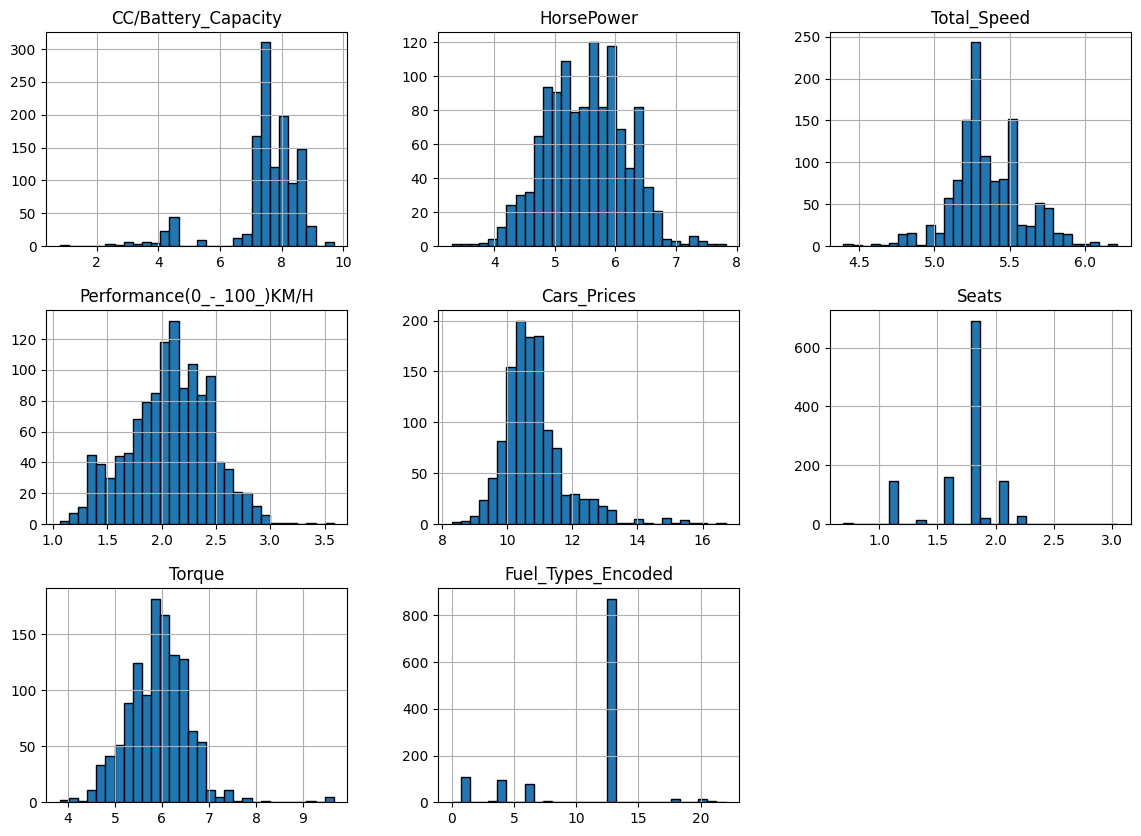

In [10]:
df.hist(figsize=(14,10), bins=30, edgecolor='black')
plt.show()

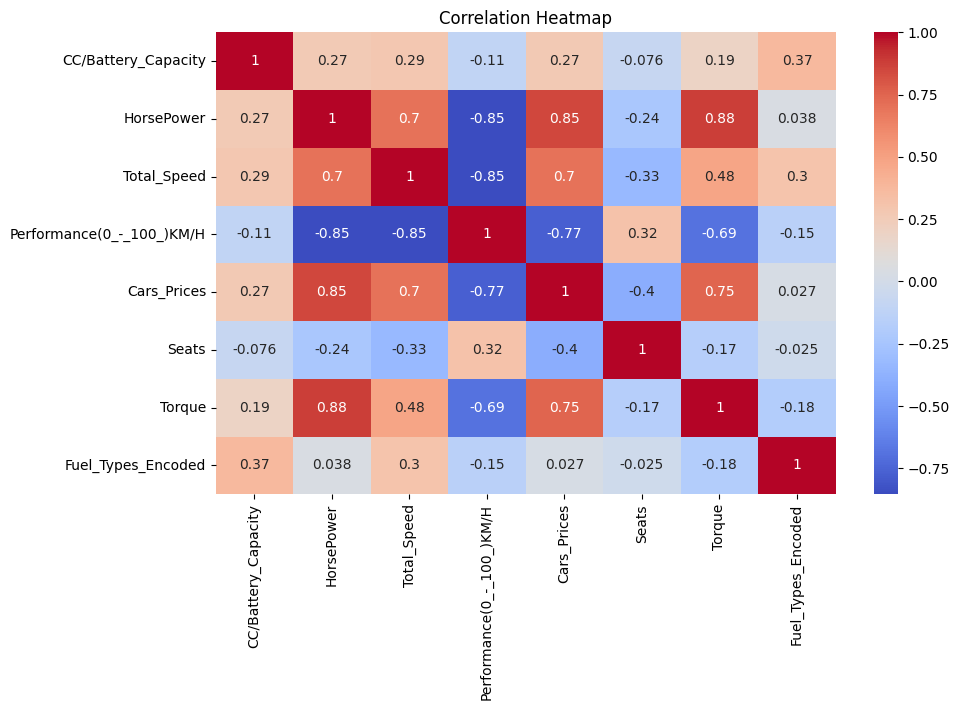

In [11]:
corr = df.corr(numeric_only=True)

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

#### Removing outliers

In [12]:
numeric_df = df[numeric_cols].copy()

In [13]:
# --- Z-SCORE ---
z_scores = np.abs(stats.zscore(numeric_df))
z_outliers = (z_scores > 3).any(axis=1)
print("Z-Score Outliers Detected:", z_outliers.sum())
df_z = df.copy()
df_z = df_z[~z_outliers]

Z-Score Outliers Detected: 65


In [14]:
# --- IQR ---
Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)
IQR = Q3 - Q1
iqr_outliers = ((numeric_df < (Q1 - 1.5 * IQR)) | (numeric_df > (Q3 + 1.5 * IQR))).any(axis=1)
print("IQR Outliers Detected:", iqr_outliers.sum())
df_iqr = df.copy()
df_iqr = df_iqr[~iqr_outliers]

IQR Outliers Detected: 471


In [15]:
# --- DBSCAN ---
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df.fillna(0))
db = DBSCAN(eps=2, min_samples=5).fit(scaled_data)
db_outliers = db.labels_ == -1
print("DBSCAN Outliers Detected:", db_outliers.sum())
df_db = df.copy()
df_db = df_db[~db_outliers]

DBSCAN Outliers Detected: 5


#### Plotting after removing outliers (Z-score method)

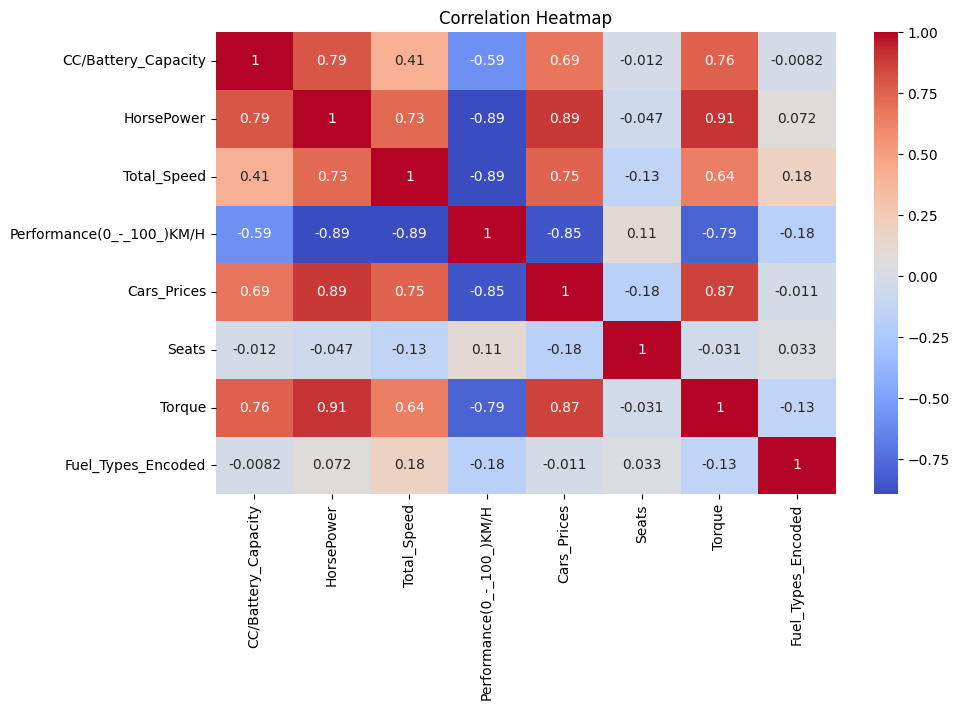

In [16]:
corr = df_iqr.corr(numeric_only=True)

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

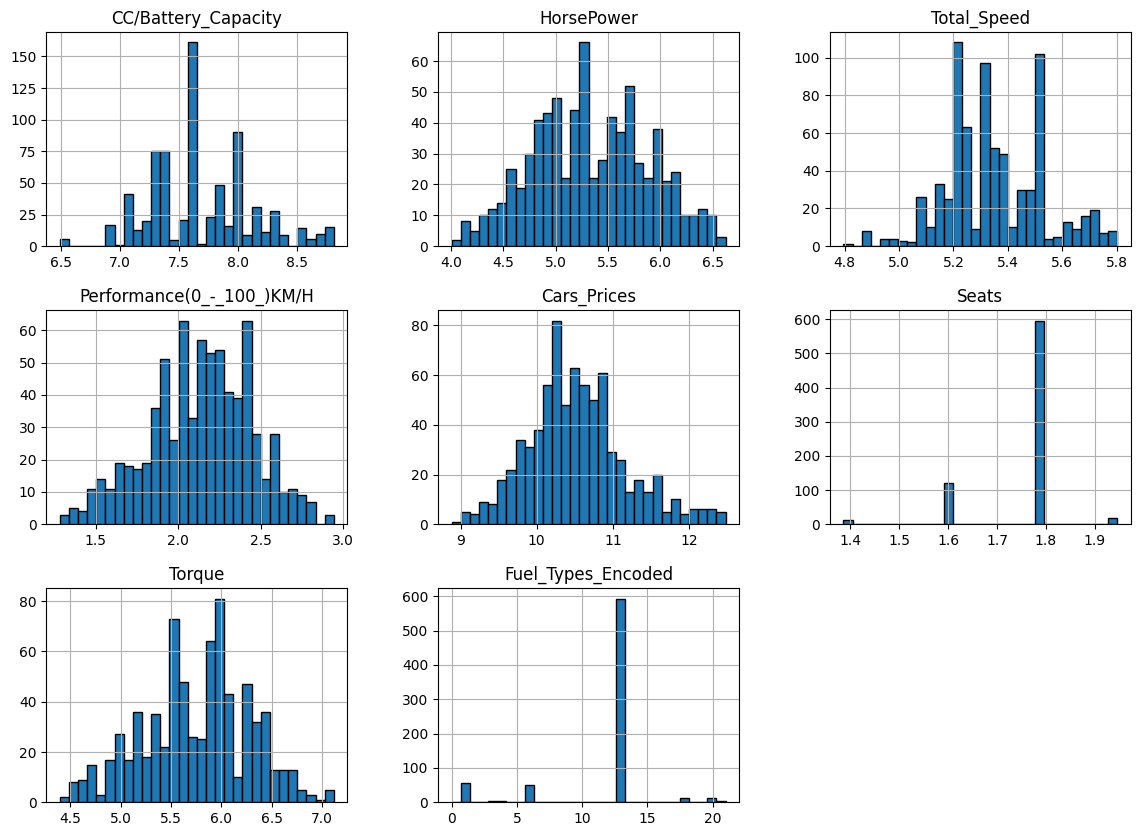

In [17]:
df_iqr.hist(figsize=(14,10), bins=30, edgecolor='black')
plt.show()

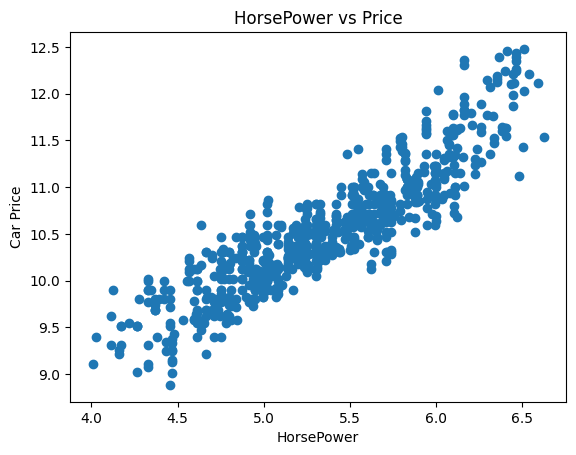

In [18]:
plt.scatter(df_iqr['HorsePower'], df_iqr['Cars_Prices']) 
plt.xlabel("HorsePower") 
plt.ylabel("Car Price") 
plt.title("HorsePower vs Price") 
plt.show()

#### Linear Regression

In [19]:
X = pd.DataFrame(df_iqr["HorsePower"])
y = pd.DataFrame(df_iqr["Cars_Prices"])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [22]:
y_pred = lin_reg.predict(X_test)

print("Linear Regression:")
#print(lin_reg.score())
print("  R^2 Score:", r2_score(y_test, y_pred))
print("  MSE:", mean_squared_error(y_test, y_pred))

Linear Regression:
  R^2 Score: 0.7678833038634123
  MSE: 0.08772400979707219


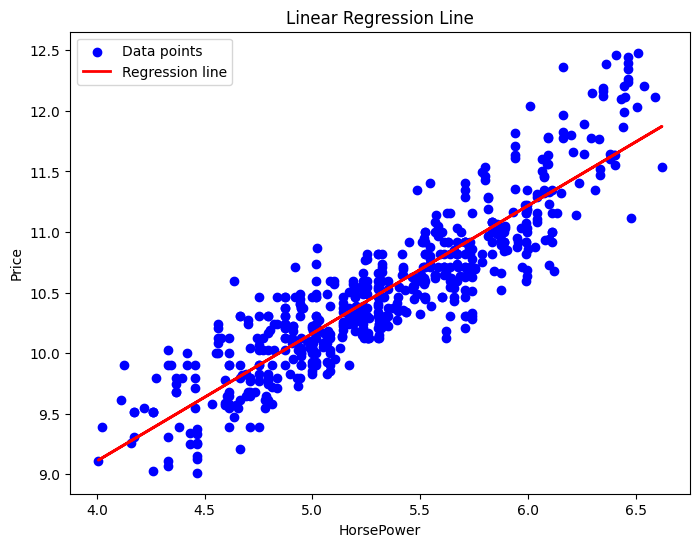

In [23]:
from mpl_toolkits.mplot3d import Axes3D

if X_train.shape[1] == 1:
    plt.figure(figsize=(8,6))
    plt.scatter(X_train, y_train, color="blue", label="Data points")
    plt.plot(X_train, lin_reg.predict(X_train), color="red", linewidth=2, label="Regression line")
    plt.xlabel(X_train.columns[0])
    plt.ylabel("Price")
    plt.title("Linear Regression Line")
    plt.legend()
    plt.show()
    
elif X_train.shape[1] == 2:
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_train.iloc[:,0], X_train.iloc[:,1], y_train, c='blue', marker='o', alpha=0.5, label="Data points")
    x_surf, y_surf = np.meshgrid(np.linspace(X_train.iloc[:,0].min(), X_train.iloc[:,0].max(), 20),
                                 np.linspace(X_train.iloc[:,1].min(), X_train.iloc[:,1].max(), 20))
    z_pred = lin_reg.predict(np.c_[x_surf.ravel(), y_surf.ravel()])
    z_surf = z_pred.reshape(x_surf.shape)
    ax.plot_surface(x_surf, y_surf, z_surf, color='red', alpha=0.5)
    ax.set_xlabel(X_train.columns[0])
    ax.set_ylabel(X_train.columns[1])
    ax.set_zlabel("Price")
    ax.set_title("Multiple Linear Regression Plane")
    ax.legend()
    plt.show()

else:
    feature = X_train.columns[0]
    plt.figure(figsize=(8,6))
    plt.scatter(X_train[feature], y_train, color="blue", label="Data points")
    plt.plot(X_train[feature], lin_reg.predict(X_train), color="red", linewidth=2, label="Regression fit (slice)")
    plt.xlabel(feature)
    plt.ylabel("Price")
    plt.title(f"Regression Line using {feature}")
    plt.legend()
    plt.show()

In [24]:
scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler()
}

for name, scaler in scalers.items():
    print(f"\n========== {name} ==========")
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42)
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    y_pred = lin_reg.predict(X_test)
    print("Linear Regression:")
    print("  MSE:", (mean_squared_error(y_test, y_pred)))
    print("  R² Score:", r2_score(y_test, y_pred))


========== StandardScaler ==========
Linear Regression:
  MSE: 0.08772400979707227
  R² Score: 0.7678833038634121

========== MinMaxScaler ==========
Linear Regression:
  MSE: 0.08772400979707223
  R² Score: 0.7678833038634122

========== RobustScaler ==========
Linear Regression:
  MSE: 0.08772400979707229
  R² Score: 0.7678833038634121


#### Logistic Regression

In [25]:
df2 = df_iqr.copy()

In [26]:
df2['Price_Up'] = (df2['Cars_Prices'].diff() > 0).astype(int)

In [35]:
#numeric_cols = df2.select_dtypes(include=[np.number]).columns
X_log = df2[["HorsePower", "Torque"]].values
y_log = df2["Price_Up"].values

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_log, y_log, test_size=0.2, random_state=42)

In [37]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)

LogisticRegression()

In [38]:
y_pred = log_reg.predict(X_test_scaled)

In [39]:
print("Logistic Regression:")
print("  R^2 Score:", r2_score(y_test, y_pred))
print("  MSE:", mean_squared_error(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Logistic Regression:
  R^2 Score: -0.3486782952706351
  MSE: 0.3333333333333333
Accuracy: 0.6666666666666666
Precision: 0.6941176470588235
Recall: 0.7108433734939759
F1 Score: 0.7023809523809523


In [40]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.61      0.62        67
           1       0.69      0.71      0.70        83

    accuracy                           0.67       150
   macro avg       0.66      0.66      0.66       150
weighted avg       0.67      0.67      0.67       150



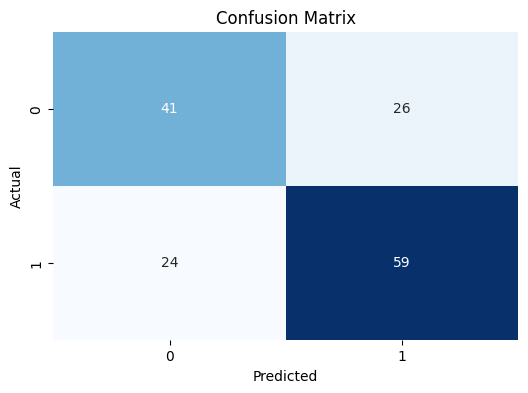

In [41]:
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

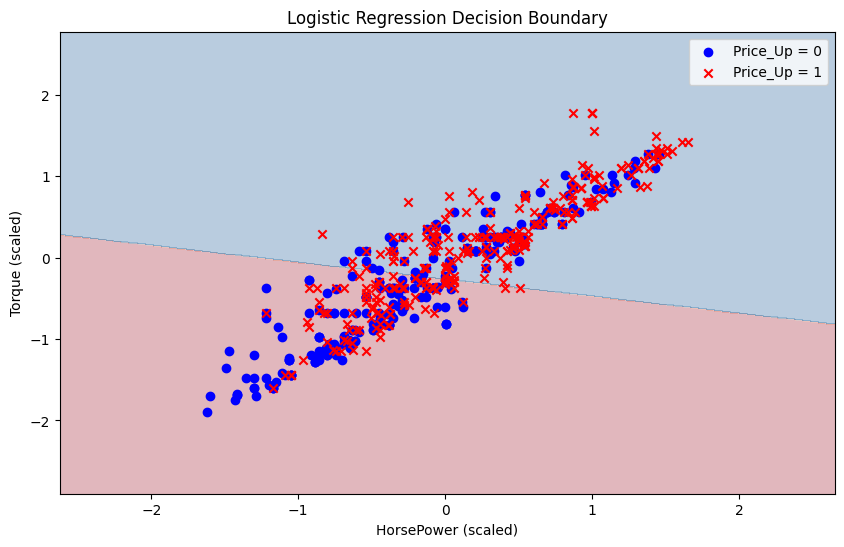

In [43]:
x_min, x_max = X_train_scaled[:, 0].min() - 1, X_train_scaled[:, 0].max() + 1
y_min, y_max = X_train_scaled[:, 1].min() - 1, X_train_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
Z = log_reg.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

#x_range = np.linspace(X_train_scaled.min()-1, X_train_scaled.max()+1, 300).reshape(-1,1)
#y_proba = log_reg.predict_proba(x_range)[:,1]

plt.figure(figsize=(10,6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdBu)
plt.scatter(X_train_scaled[y_train==0, 0], X_train_scaled[y_train==0, 1],
            color="blue", marker="o", label="Price_Up = 0")
plt.scatter(X_train_scaled[y_train==1, 0], X_train_scaled[y_train==1, 1],
            color="red", marker="x", label="Price_Up = 1")
plt.xlabel("HorsePower (scaled)")
plt.ylabel("Torque (scaled)")
plt.title("Logistic Regression Decision Boundary")
plt.legend()

#plt.plot(x_range, y_proba, color="black", linewidth=2, label="Logistic Regression Curve")
plt.show()


========== StandardScaler ==========
Logistic Regression:
  RMSE: 0.5773502691896257
  R² Score: -0.3486782952706351
Accuracy: 0.6666666666666666
Precision: 0.6941176470588235
Recall: 0.7108433734939759
F1 Score: 0.7023809523809523

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.61      0.62        67
           1       0.69      0.71      0.70        83

    accuracy                           0.67       150
   macro avg       0.66      0.66      0.66       150
weighted avg       0.67      0.67      0.67       150



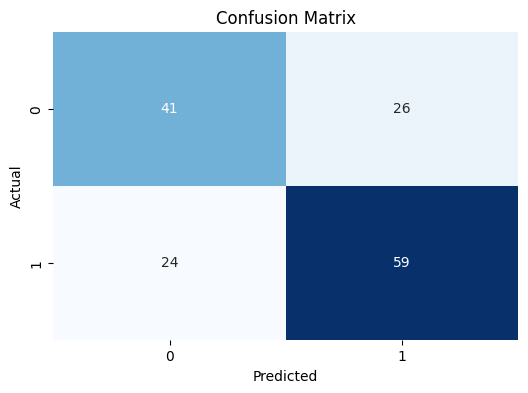


========== MinMaxScaler ==========
Logistic Regression:
  RMSE: 0.5715476066494082
  R² Score: -0.32170472936522243
Accuracy: 0.6733333333333333
Precision: 0.6888888888888889
Recall: 0.7469879518072289
F1 Score: 0.7167630057803468

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.58      0.61        67
           1       0.69      0.75      0.72        83

    accuracy                           0.67       150
   macro avg       0.67      0.66      0.67       150
weighted avg       0.67      0.67      0.67       150



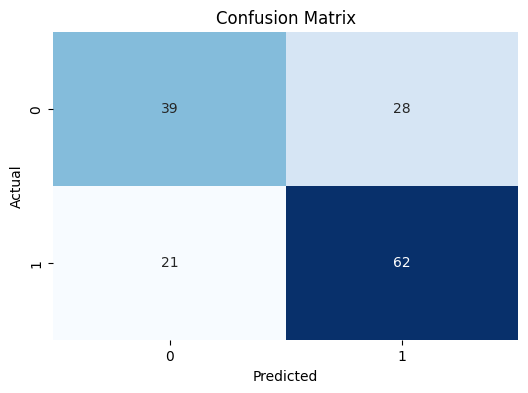


========== RobustScaler ==========
Logistic Regression:
  RMSE: 0.5773502691896257
  R² Score: -0.3486782952706351
Accuracy: 0.6666666666666666
Precision: 0.6941176470588235
Recall: 0.7108433734939759
F1 Score: 0.7023809523809523

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.61      0.62        67
           1       0.69      0.71      0.70        83

    accuracy                           0.67       150
   macro avg       0.66      0.66      0.66       150
weighted avg       0.67      0.67      0.67       150



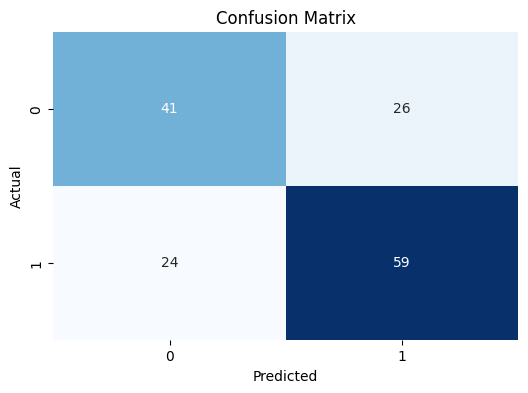

In [44]:
scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler()
}

for name, scaler in scalers.items():
    print(f"\n========== {name} ==========")
    X_scaled = scaler.fit_transform(X_log)
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_log, test_size=0.2, random_state=42)
    log_reg = LogisticRegression()
    log_reg.fit(X_train, y_train)
    y_pred = log_reg.predict(X_test)
    print("Logistic Regression:")
    print("  RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("  R² Score:", r2_score(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    plt.figure(figsize=(6,4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

#### Filtering dataframe by specific car company

##### Linear Regression

df_z[df_z['Cars_Names'] == 'PHANTOM']

In [45]:
df_filtered = df_iqr[df_iqr["Company_Names"].str.upper().isin(["NISSAN"])]
#df_filtered = df_filtered[df_filtered["Cars_Names"].str.upper().isin(["PHANTOM"])]

In [48]:
numeric_cols = df_filtered.select_dtypes(include=[np.number]).columns
#X = df_filtered[numeric_cols].drop(columns=["Cars_Prices"])
X = df_filtered[["HorsePower"]]
y = df_filtered["Cars_Prices"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)
print("Linear Regression:")
print("  R^2 Score:", r2_score(y_test, y_pred))
print("  MSE:", mean_squared_error(y_test, y_pred))

Linear Regression:
  R^2 Score: 0.824394871126225
  MSE: 0.05484154769397716


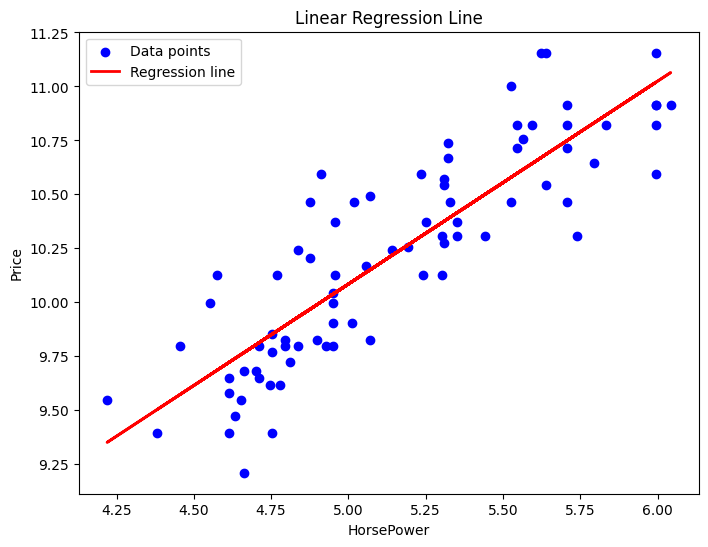

In [49]:
from mpl_toolkits.mplot3d import Axes3D

if X_train.shape[1] == 1:
    plt.figure(figsize=(8,6))
    plt.scatter(X_train, y_train, color="blue", label="Data points")
    plt.plot(X_train, lin_reg.predict(X_train), color="red", linewidth=2, label="Regression line")
    plt.xlabel(X_train.columns[0])
    plt.ylabel("Price")
    plt.title("Linear Regression Line")
    plt.legend()
    plt.show()
    
elif X_train.shape[1] == 2:
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_train.iloc[:,0], X_train.iloc[:,1], y_train, c='blue', marker='o', alpha=0.5, label="Data points")
    x_surf, y_surf = np.meshgrid(np.linspace(X_train.iloc[:,0].min(), X_train.iloc[:,0].max(), 20),
                                 np.linspace(X_train.iloc[:,1].min(), X_train.iloc[:,1].max(), 20))
    z_pred = lin_reg.predict(np.c_[x_surf.ravel(), y_surf.ravel()])
    z_surf = z_pred.reshape(x_surf.shape)
    ax.plot_surface(x_surf, y_surf, z_surf, color='red', alpha=0.5)
    ax.set_xlabel(X_train.columns[0])
    ax.set_ylabel(X_train.columns[1])
    ax.set_zlabel("Price")
    ax.set_title("Multiple Linear Regression Plane")
    ax.legend()
    plt.show()

else:
    feature = X_train.columns[0]
    plt.figure(figsize=(8,6))
    plt.scatter(X_train[feature], y_train, color="blue", label="Data points")
    plt.plot(X_train[feature], lin_reg.predict(X_train), color="red", linewidth=2, label="Regression fit (slice)")
    plt.xlabel(feature)
    plt.ylabel("Price")
    plt.title(f"Regression Line using {feature}")
    plt.legend()
    plt.show()

In [50]:
scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler()
}

for name, scaler in scalers.items():
    print(f"\n========== {name} ==========")
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42)
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    y_pred = lin_reg.predict(X_test)
    print("Linear Regression:")
    print("  RMSE:", mean_squared_error(y_test, y_pred))
    print("  R² Score:", r2_score(y_test, y_pred))


========== StandardScaler ==========
Linear Regression:
  RMSE: 0.054841547693977095
  R² Score: 0.8243948711262252

========== MinMaxScaler ==========
Linear Regression:
  RMSE: 0.05484154769397716
  R² Score: 0.824394871126225

========== RobustScaler ==========
Linear Regression:
  RMSE: 0.054841547693977116
  R² Score: 0.8243948711262251


##### Logistic Regression

In [51]:
df_filtered2 = df_filtered.copy()

In [52]:
df_filtered2['Price_Up'] = (df_filtered2['Cars_Prices'].diff() > 0).astype(int)

In [53]:
numeric_cols = df_filtered2.select_dtypes(include=[np.number]).columns
X_log = df_filtered2[["HorsePower", "Torque"]].values
y_log = df_filtered2["Price_Up"]
X_train, X_test, y_train, y_test = train_test_split(X_log, y_log, test_size=0.2, random_state=42)
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [54]:
y_pred = log_reg.predict(X_test)
print("Logistic Regression:")
print("  R^2 Score:", r2_score(y_test, y_pred))
print("  MSE:", mean_squared_error(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Logistic Regression:
  R^2 Score: 0.02777777777777768
  MSE: 0.23809523809523808
Accuracy: 0.7619047619047619
Precision: 0.7
Recall: 0.7777777777777778
F1 Score: 0.7368421052631579

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.75      0.78        12
           1       0.70      0.78      0.74         9

    accuracy                           0.76        21
   macro avg       0.76      0.76      0.76        21
weighted avg       0.77      0.76      0.76        21



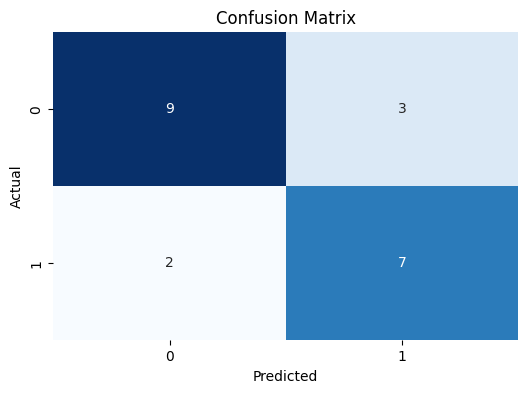

In [55]:
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

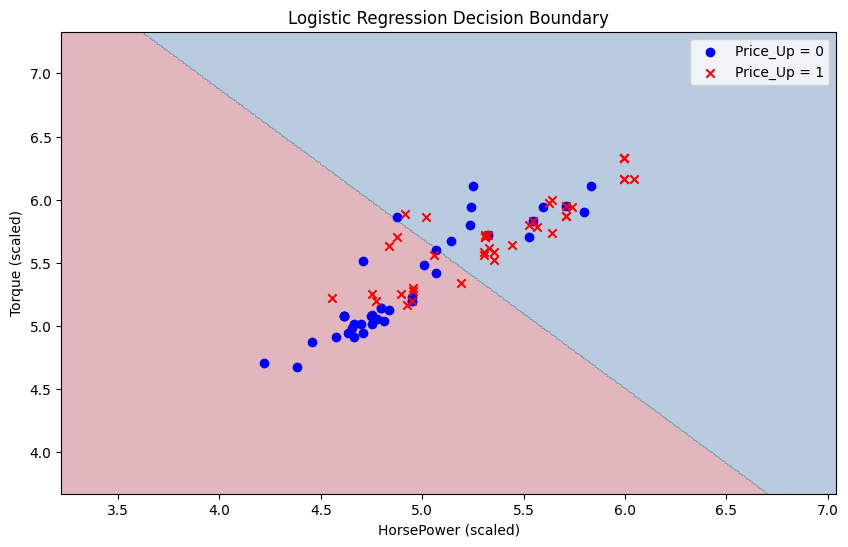

In [58]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
Z = log_reg.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

#x_range = np.linspace(X_train_scaled.min()-1, X_train_scaled.max()+1, 300).reshape(-1,1)
#y_proba = log_reg.predict_proba(x_range)[:,1]

plt.figure(figsize=(10,6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdBu)
plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1],
            color="blue", marker="o", label="Price_Up = 0")
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1],
            color="red", marker="x", label="Price_Up = 1")
plt.xlabel("HorsePower (scaled)")
plt.ylabel("Torque (scaled)")
plt.title("Logistic Regression Decision Boundary")
plt.legend()

#plt.plot(x_range, y_proba, color="black", linewidth=2, label="Logistic Regression Curve")
plt.show()


========== StandardScaler ==========
Logistic Regression:
  RMSE: 0.4879500364742666
  R² Score: 0.02777777777777768
Accuracy: 0.7619047619047619
Precision: 0.7
Recall: 0.7777777777777778
F1 Score: 0.7368421052631579

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.75      0.78        12
           1       0.70      0.78      0.74         9

    accuracy                           0.76        21
   macro avg       0.76      0.76      0.76        21
weighted avg       0.77      0.76      0.76        21



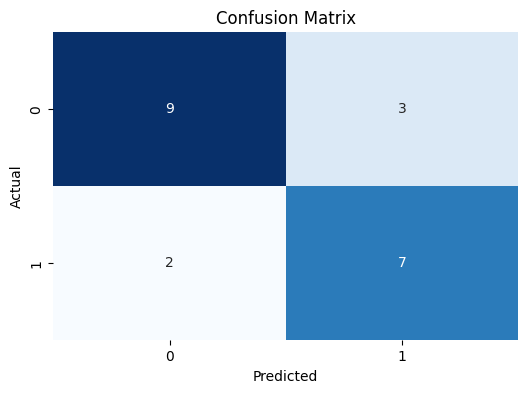


========== MinMaxScaler ==========
Logistic Regression:
  RMSE: 0.4879500364742666
  R² Score: 0.02777777777777768
Accuracy: 0.7619047619047619
Precision: 0.7
Recall: 0.7777777777777778
F1 Score: 0.7368421052631579

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.75      0.78        12
           1       0.70      0.78      0.74         9

    accuracy                           0.76        21
   macro avg       0.76      0.76      0.76        21
weighted avg       0.77      0.76      0.76        21



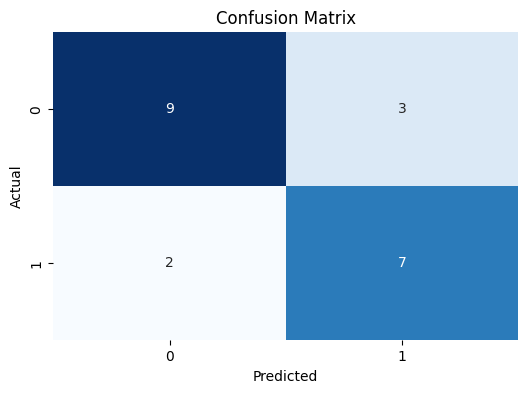


========== RobustScaler ==========
Logistic Regression:
  RMSE: 0.4879500364742666
  R² Score: 0.02777777777777768
Accuracy: 0.7619047619047619
Precision: 0.7
Recall: 0.7777777777777778
F1 Score: 0.7368421052631579

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.75      0.78        12
           1       0.70      0.78      0.74         9

    accuracy                           0.76        21
   macro avg       0.76      0.76      0.76        21
weighted avg       0.77      0.76      0.76        21



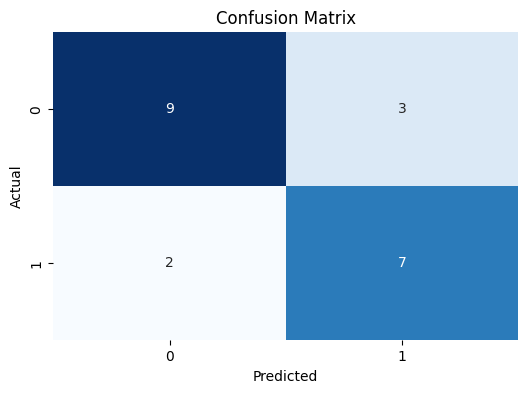

In [59]:
scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler()
}

for name, scaler in scalers.items():
    print(f"\n========== {name} ==========")
    X_scaled = scaler.fit_transform(X_log)
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_log, test_size=0.2, random_state=42)
    log_reg = LogisticRegression()
    log_reg.fit(X_train, y_train)
    y_pred = log_reg.predict(X_test)
    print("Logistic Regression:")
    print("  RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("  R² Score:", r2_score(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    plt.figure(figsize=(6,4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()